# Quantum pipeline using the Quantum Trainer

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [1]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 40
SEED = 2

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


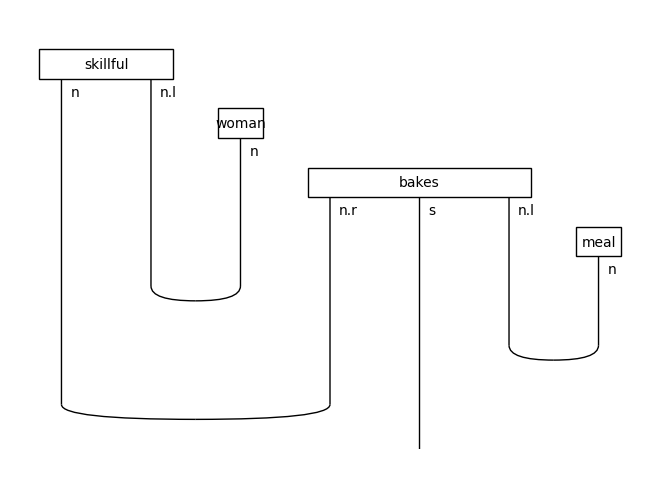

In [6]:
raw_train_diagrams[13].draw()

### Remove the cups

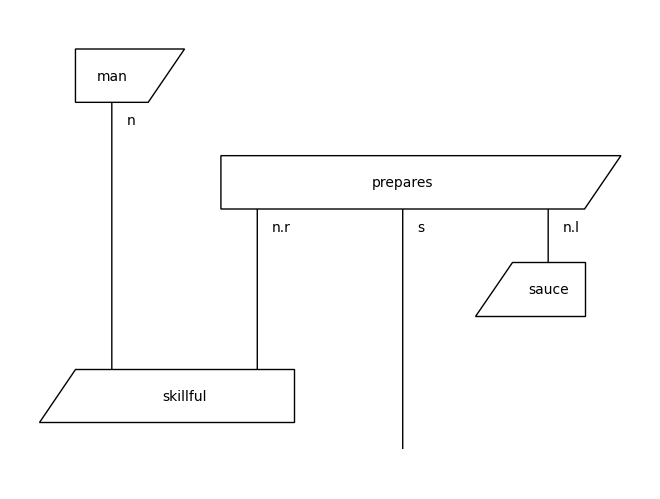

In [7]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

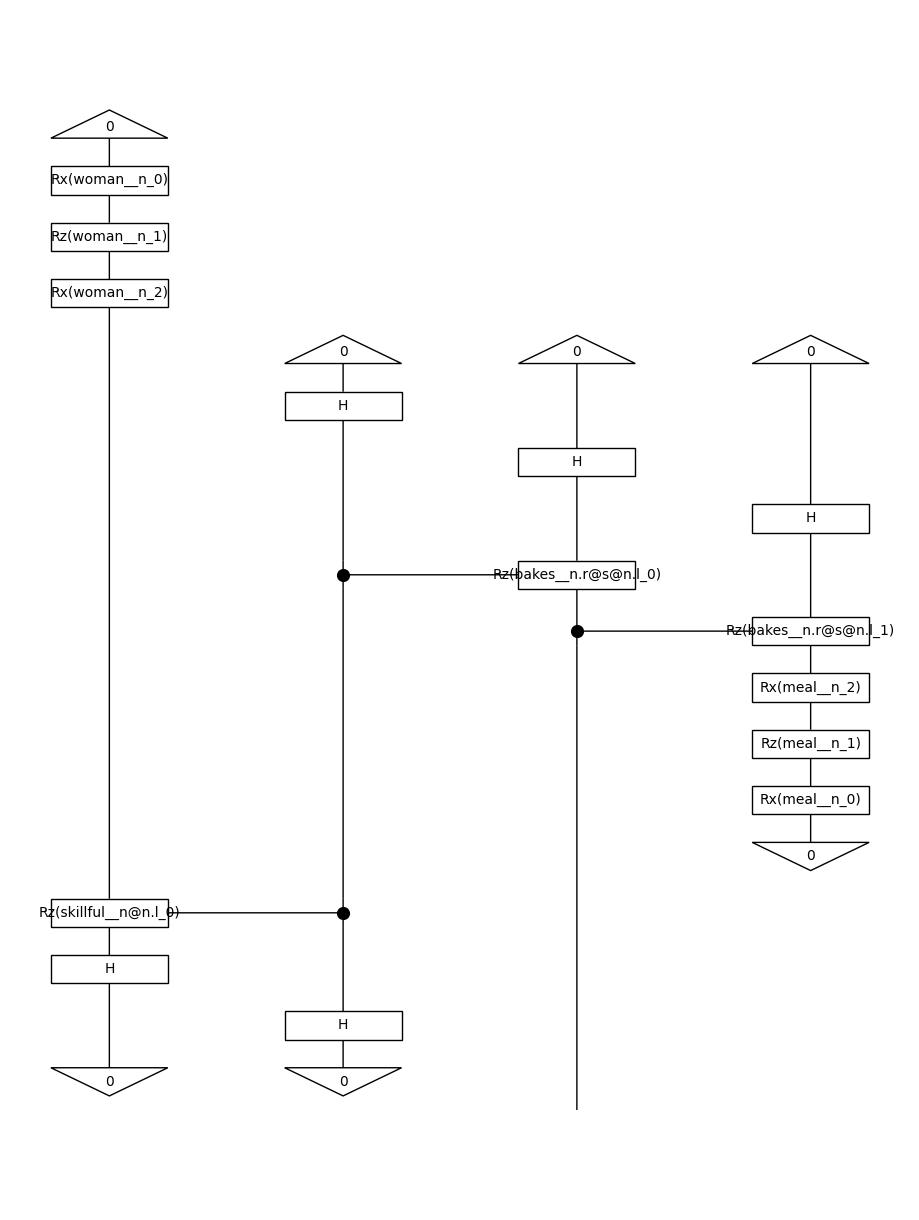

In [8]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[13].draw(figsize=(9, 12))

### Parameterise

In [11]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)


### Define evaluation metric

In [12]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [13]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [14]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [18]:
trainer.fit(train_dataset, val_dataset, logging_step=1)

Epoch 1:   train/loss: 1.0964   valid/loss: 0.7262   train/acc: 0.4789   valid/acc: 0.7333
Epoch 2:   train/loss: 1.9049   valid/loss: 1.3607   train/acc: 0.5070   valid/acc: 0.5000
Epoch 3:   train/loss: 1.3293   valid/loss: 1.5521   train/acc: 0.6127   valid/acc: 0.5500
Epoch 4:   train/loss: 1.4612   valid/loss: 0.9189   train/acc: 0.3873   valid/acc: 0.4500
Epoch 5:   train/loss: 1.4031   valid/loss: 0.7008   train/acc: 0.4648   valid/acc: 0.6000
Epoch 6:   train/loss: 1.5503   valid/loss: 1.3130   train/acc: 0.4789   valid/acc: 0.5500
Epoch 7:   train/loss: 0.8048   valid/loss: 0.6173   train/acc: 0.5915   valid/acc: 0.6667
Epoch 8:   train/loss: 0.8284   valid/loss: 1.8594   train/acc: 0.5352   valid/acc: 0.4500
Epoch 9:   train/loss: 0.8355   valid/loss: 0.8211   train/acc: 0.5634   valid/acc: 0.5333
Epoch 10:  train/loss: 0.8792   valid/loss: 1.8117   train/acc: 0.5704   valid/acc: 0.6667
Epoch 11:  train/loss: 0.7574   valid/loss: 1.3078   train/acc: 0.5775   valid/acc: 0.5667

In [20]:
model(train_circuits[0])

ValueError: could not broadcast input array from shape (2,2,2,2) into shape (2,)

### Show results

Test accuracy: 0.8


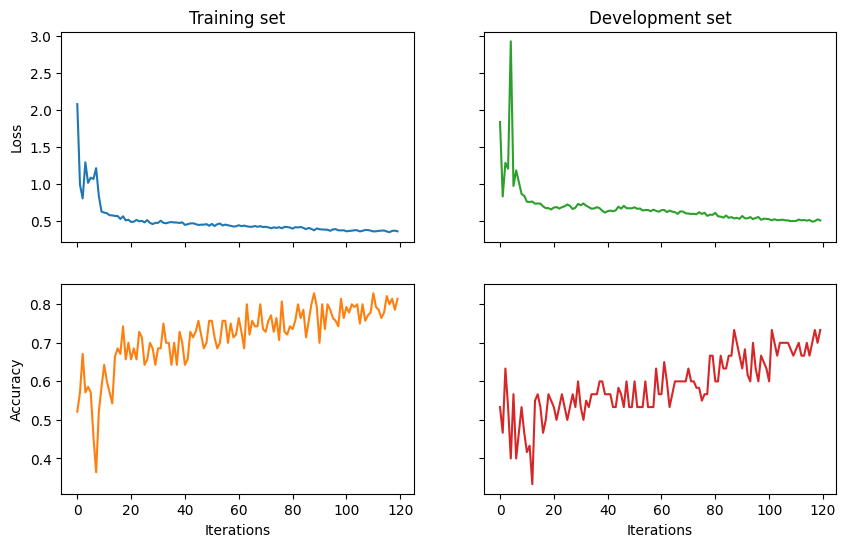

In [25]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)